# 1. 들어가며

---

오늘은 전자상거래 플랫폼에서 많이 사용하는 Session-Based Recommendation에 대해 알아보자. **바로 지금 시점에 고객이 좋아할 상품**을 추천해주기 위해 **유저의 다음 클릭 혹은 구매할 아이템을 예측하는 추천**이 필요하다.

Session-based Recommendation은 말 그대로 세션 데이터를 기반으로 **유저가 다음에 클릭, 구매할 아이템을 예측하는 추천**을 말한다. Session이란, 유저가 서비스를 이용하면서 발생하는 중요한 정보를 담은 데이터를 말한다.

이번 자료에서 세션은 `브라우저가 종료되기 전까지 유저의 행동을 담은 시퀀스 데이터`라고 하자.

[쿠키, 세션, 캐시](https://youtu.be/OpoVuwxGRDI)

[쿠키, 세션이란?](https://medium.com/@chrisjune_13837/web-%EC%BF%A0%ED%82%A4-%EC%84%B8%EC%85%98%EC%9D%B4%EB%9E%80-aa6bcb327582)

```python
프로젝트 폴더를 만들고, 데이터 폴더에서 프로젝트 폴더로 링크를 연결해 주세요!

$ mkdir -p ~/aiffel/yoochoose/data
$ ln -s ~/data/* ~/aiffel/yoochoose/data
```

In [2]:
# 데이터 설명(README)를 읽어 봅니다. 
import os
f = open(os.getenv('HOME')+'/aiffel/yoochoose/data/dataset-README.txt', 'r')
while True:
    line = f.readline()
    if not line: break
    print(line)
f.close()

﻿SUMMARY




This dataset was constructed by YOOCHOOSE GmbH to support participants in the RecSys Challenge 2015.

See  http://recsys.yoochoose.net for details about the challenge.



The YOOCHOOSE dataset contain a collection of sessions from a retailer, where each session

is encapsulating the click events that the user performed in the session.

For some of the sessions, there are also buy events; means that the session ended

with the user bought something from the web shop. The data was collected during several

months in the year of 2014, reflecting the clicks and purchases performed by the users

of an on-line retailer in Europe.  To protect end users privacy, as well as the retailer,

all numbers have been modified. Do not try to reveal the identity of the retailer.



LICENSE


This dataset is licensed under the Creative Commons Attribution-NonCommercial-NoDerivatives 4.0

International License. To view a copy of this license, visit http://creativecommons.org/licenses/by-nc-nd

데이터 설명을 읽어보면 몇 가지 주목할 점이 있다.

1. 유저에 대한 정보를 전혀 알 수 없다.(성별, 나이, 장소, 마지막 접속 날짜 등)   
2. 아이템에 대한 정보를 전혀 알 수 없다.(어떤 물건인지, 사진, 설명 등)

또한 E-Commerce 데이터의 경우 다음과 같은 특징을 갖는다.

1. 비로그인 상태로 탐색하는 유저가 많다.   
2. 로그인 상태로 탐색하더라도, 접속할 때마다 탐색하는 의도가 분명하다.   

# 2. Data Preprocess
---

## 2.1. Data Load
---

- 데이터를 불러와 살펴보고 주요 통계치들을 살펴보자.   
- Click 데이터에 있는 Session Id, TimeStamp, ItemId 칼럼만 사용하자.   

[pathlib 라이브러리 설명](https://docs.python.org/3/library/pathlib.html)

In [3]:
import datetime as dt
from pathlib import Path
import os

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [4]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data') 
train_path = data_path / 'yoochoose-clicks.dat'
train_path

PosixPath('/aiffel/aiffel/yoochoose/data/yoochoose-clicks.dat')

In [5]:
def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep=',', header=None, usecols=[0, 1, 2],
                       parse_dates=[1], dtype={0: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['SessionId', 'Time', 'ItemId']
    return data

In [6]:
# 시간이 좀 걸릴 수 있습니다. 메모리도 10GB 가까이 소요될 수 있으니 메모리 상태에 주의해 주세요.  

data = load_data(train_path, None)
data.sort_values(['SessionId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,SessionId,Time,ItemId
0,1,2014-04-07 10:51:09.277000+00:00,214536502
1,1,2014-04-07 10:54:09.868000+00:00,214536500
2,1,2014-04-07 10:54:46.998000+00:00,214536506
3,1,2014-04-07 10:57:00.306000+00:00,214577561
4,2,2014-04-07 13:56:37.614000+00:00,214662742
...,...,...,...
32230487,11562158,2014-09-26 04:50:29.172000+00:00,214849132
32230488,11562158,2014-09-26 04:52:21.900000+00:00,214854774
32230489,11562158,2014-09-26 05:16:32.904000+00:00,214849132
32230490,11562159,2014-09-26 19:16:28.897000+00:00,214849132


In [7]:
# 추천시스템을 구축할 때 가장 먼저 확인할 것은 유저수(세션 수)와 아이템 수이다.
data['SessionId'].nunique(), data['ItemId'].nunique()

(9249729, 52739)

## 2.2. Session Length
---

각 세션이 대략 몇 개의 클릭 데이터를 갖는지도 살펴보자.



In [9]:
session_length = data.groupby('SessionId').size()
session_length

SessionId
1           4
2           6
3           3
4           2
6           2
           ..
11562156    2
11562157    2
11562158    3
11562159    1
11562161    1
Length: 9249729, dtype: int64

여기서 `session_length`란 같은 `SessionId`를 공유하는 데이터 row의 개수를 의미한다. 여기서 `SessionId`란 브라우저에서 웹서버로 접속할 때 항상 포함하게 되는 유저 구분자이다. 로그인하지 않았기 때문에 이 사용자가 누군지를 몰라도, 최소한 특정 사용자의 행동을 `SessionId` 기준으로 모아서 분류해낼 수는 있다. 따라서 여기서 `session_length`란 해당 세션의 사용자가 그 세션 동안 몇 번의 액션을 취했는지 의미한다.

In [10]:
session_length.median(), session_length.mean()

(2.0, 3.568098481587947)

In [11]:
session_length.min(), session_length.max()

(1, 200)

In [12]:
session_length.quantile(0.999)

41.0

각 세션은 보통 2 ~ 3 정도의 길이를 갖는다. 99.9% 세션은 길이가 41이하이다.

길이가 200인 세션은 무언가 이상하므로, 하나를 잡고 살펴보자.

In [14]:
long_session = session_length[session_length==200].index[0]
data[data['SessionId']==long_session]

,SessionId,Time,ItemId
580293,189448,2014-04-01 08:56:28.983000+00:00,214830392
580294,189448,2014-04-01 08:56:31.815000+00:00,214830392
580295,189448,2014-04-01 08:57:08.301000+00:00,214830392
580296,189448,2014-04-01 08:57:10.338000+00:00,214830392
580297,189448,2014-04-01 08:58:01.728000+00:00,214830390
...,...,...,...
580488,189448,2014-04-01 10:35:52.400000+00:00,214830137
580489,189448,2014-04-01 10:37:15.094000+00:00,214830118
580490,189448,2014-04-01 10:37:35.955000+00:00,214830118
580491,189448,2014-04-01 10:37:37.098000+00:00,214830118


Time Column을 보면 매우 짧은 간격으로 클릭을 하고 있다. 유저들의 서비스 이용행태는 다양하기 때문에 데이터 전처리를 어떻게 할지는 모델을 만드는 사람이 판단해야 한다.

세션 길이에 대한 감을 파악하기 위해 시각화를 해 보자.

In [15]:
# 세션 길이 기준 하위 99.9%까지의 분포 누적합
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

1     0.136189
2     0.520858
3     0.695280
4     0.796461
5     0.855125
6     0.894389
7     0.920036
8     0.938321
9     0.951293
10    0.961084
11    0.968267
12    0.973959
13    0.978320
14    0.981815
15    0.984587
16    0.986837
17    0.988673
18    0.990201
19    0.991460
20    0.992520
21    0.993436
22    0.994207
23    0.994871
24    0.995444
25    0.995920
26    0.996342
27    0.996714
28    0.997042
29    0.997330
30    0.997577
31    0.997796
32    0.998001
33    0.998177
34    0.998327
35    0.998461
36    0.998590
37    0.998706
38    0.998805
39    0.998896
40    0.998981
dtype: float64

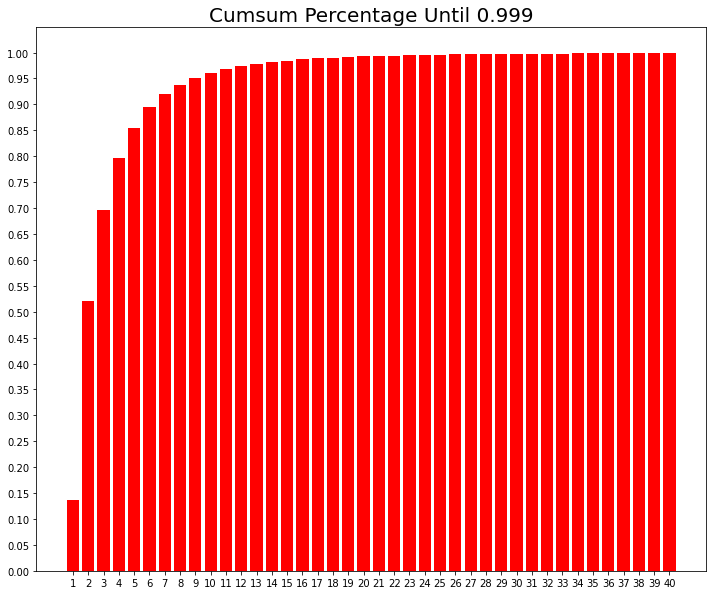

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

## 2.3. Session Time

---

추천 시스템을 구축할 때는 최근 소비 트렌드를 학습하는 것이 중요하다. 이번엔 데이터가 발생한 시간에 대해 알아보자.

먼저 우리가 다룰 데이터의 시간 정보를 확인하자.

In [19]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)

2014-04-01 03:00:00.124000+00:00
2014-09-30 02:59:59.430000+00:00


In [20]:
type(latest)

pandas._libs.tslibs.timestamps.Timestamp

latest는 Timestamp 객체이기 때문에 int와의 사칙연산을 지원하지 않는다. 날짜끼리의 차이를 구하고 싶을 때는 datetime 라이브러리의 timedelta 객체를 사용하자.

In [21]:
month_ago = latest - dt.timedelta(30)     # 최종 날짜로부터 30일 이전 날짜를 구한다.  
data = data[data['Time'] > month_ago]   # 방금 구한 날짜 이후의 데이터만 모은다. 
data

,SessionId,Time,ItemId
26837834,9194111,2014-08-31 17:40:46.805000+00:00,214853420
26837835,9194111,2014-08-31 17:42:26.089000+00:00,214850942
26837836,9194111,2014-08-31 17:44:06.583000+00:00,214829878
26837837,9194111,2014-08-31 17:48:49.873000+00:00,214853420
26838214,9194112,2014-09-01 13:26:36.292000+00:00,214853422
...,...,...,...
32230487,11562158,2014-09-26 04:50:29.172000+00:00,214849132
32230488,11562158,2014-09-26 04:52:21.900000+00:00,214854774
32230489,11562158,2014-09-26 05:16:32.904000+00:00,214849132
32230490,11562159,2014-09-26 19:16:28.897000+00:00,214849132


In [ ]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)

## 2.4. Data Cleansing 

---
우리의 목적은 유저가 최소 1개 이상 클릭했을 때 **다음 클릭을 예측**하는 것이므로, 길이가 1인 세션은 제거해 준다.

그리고, 너무 적게 클릭된 아이템도 제거해 준다.

In [22]:
# short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있습니다.
# 이를 위해 반복문을 통해 지속적으로 제거 합니다.
def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('SessionId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['SessionId'].isin(session_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [23]:
data = cleanse_recursive(data, shortest=2, least_click=5)
data

,SessionId,Time,ItemId
26837834,9194111,2014-08-31 17:40:46.805000+00:00,214853420
26837835,9194111,2014-08-31 17:42:26.089000+00:00,214850942
26837836,9194111,2014-08-31 17:44:06.583000+00:00,214829878
26837837,9194111,2014-08-31 17:48:49.873000+00:00,214853420
26838202,9194123,2014-08-31 19:26:57.386000+00:00,214601207
...,...,...,...
32230485,11562157,2014-09-25 12:31:10.391000+00:00,214580372
32230486,11562157,2014-09-25 12:31:29.679000+00:00,214516012
32230487,11562158,2014-09-26 04:50:29.172000+00:00,214849132
32230488,11562158,2014-09-26 04:52:21.900000+00:00,214854774


## 2.5. Train, Valid, Test split

---



In [24]:
test_path = data_path / 'yoochoose-test.dat'
test= load_data(test_path)
test['Time'].min(), test['Time'].max()

(Timestamp('2014-04-01 03:00:08.250000+0000', tz='UTC'),
 Timestamp('2014-09-30 02:59:23.866000+0000', tz='UTC'))

Test set을 보니, Training set과 기간이 겹친다. 하지만 1.3에서 말했듯이, 추천 시스템은 `지금`을 잘 예측하는 게 중요하다.

1달 전 성능이 좋은 모델을 지금 쓰면 맞지 않을 수 있는데, 이는 사용자들의 소비 패턴이 달라지기 때문이다. 따라서, Session-Based Recommendation에서는 기간에 따라 Train, Valid, Test 셋을 나눈다.

In [25]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('SessionId')['Time'].max()
    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['SessionId'].isin(session_in_train)]
    after_date = data[data['SessionId'].isin(session_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

In [26]:
tr, test = split_by_date(data, n_days=1)
tr, val = split_by_date(tr, n_days=1)

In [27]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["SessionId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [28]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 5125100
	 Sessions: 1243431
	 Items: 20153
	 First Time : 2014-08-31 03:00:01.111000+00:00
	 Last Time : 2014-09-28 02:57:34.348000+00:00

* valid Set Stats Info
	 Events: 58074
	 Sessions: 12350
	 Items: 6232
	 First Time : 2014-09-28 03:00:25.298000+00:00
	 Last Time : 2014-09-29 02:58:27.660000+00:00

* test Set Stats Info
	 Events: 71009
	 Sessions: 15289
	 Items: 6580
	 First Time : 2014-09-29 02:37:20.695000+00:00
	 Last Time : 2014-09-30 02:59:59.430000+00:00



In [29]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [30]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

데이터 준비가 끝났다. 이제 data pipeline을 구축해보자.

# 3. 논문소개(GRU4REC)

---

이번 자료에서 사용할 모델은 [SESSION BASED RECOMMENDATIONS WITH RECURRENT NEURAL NETWORKS](https://arxiv.org/pdf/1511.06939v4.pdf)이다. 

모델 구조는 다음과 같으며, Embedding Layer를 사용하지 않을 때 성능이 좋다고 한다.

![image](https://user-images.githubusercontent.com/78291267/156972671-b6ab280a-c652-4221-96a7-94c9f217bf3e.png)

대신 추천 데이터의 특징 몇 가지를 살려 모델링을 했다고 한다.

![image](https://user-images.githubusercontent.com/78291267/156973284-2f257c25-9ad8-469d-9896-f51350d998b8.png)

**Session-Parallel Mnii-Batches**: 몇 개의 세션을 하나의 mini-batch로 만드는 대신에, Session이 끝날 때까지 기다리지 않고 병렬적으로 계산하는 Session-Parallel Mini-Batches를 제안한다.

이렇게 구성했을 때 Mini-Batch의 shape는 (3,1,1)이 되고 RNN cell의 state가 1개로만 이뤄진다.

![image](https://user-images.githubusercontent.com/78291267/156973289-ca211318-43cd-4dcb-a43d-0f7d3f96af04.png)



# 4. Data Pipeline
---

### 4.1. Session Dataset
---

우선 데이터가 주어지면 세션이 시작되는 인덱스를 담는 값과 세션을 새로 인덱싱한 값을 갖는 클래스를 만든다. 

In [31]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['SessionId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['SessionId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('SessionId').size().cumsum()
        return offsets

train 데이터로 `SessionDataset` 객체를 만들고 인스턴스 변수들을 살펴보자.

`click_offsets`변수는 각 세션이 시작된 인덱스를 담고 있다.

`session_idx` 변수는 각 세션을 인덱싱한 `np.array`이다.

In [32]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,SessionId,Time,ItemId,item_idx
26837834,9194111,2014-08-31 17:40:46.805000+00:00,214853420,0
26837835,9194111,2014-08-31 17:42:26.089000+00:00,214850942,1
26837836,9194111,2014-08-31 17:44:06.583000+00:00,214829878,2
26837837,9194111,2014-08-31 17:48:49.873000+00:00,214853420,0
26838202,9194123,2014-08-31 19:26:57.386000+00:00,214601207,3
26838203,9194123,2014-08-31 19:34:37.068000+00:00,214510689,4
26838193,9194124,2014-08-31 19:14:28.308000+00:00,214849327,5
26838194,9194124,2014-08-31 19:16:31.114000+00:00,214828970,6
26838196,9194127,2014-09-01 15:36:11.651000+00:00,214845997,7
26838197,9194127,2014-09-01 15:38:00.222000+00:00,214845997,7


In [33]:
tr_dataset.click_offsets

array([      0,       4,       6, ..., 5125095, 5125097, 5125100],
      dtype=int32)

In [34]:
tr_dataset.session_idx

array([      0,       1,       2, ..., 1243428, 1243429, 1243430])

### 4.2. SessionDataLoader
---
이번엔 `SessionDataset` 객체를 받아서 Session-Parallel mini-batch를 만드는 클래스를 만든다.

`__iter__` 메서드는 모델 인풋, 라벨, 세션이 끝나는 곳의 위치를 `yield`한다.

mask는 후에 RNN Cell State를 초기화할 때 사용한다.

In [35]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [36]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,SessionId,Time,ItemId,item_idx
26837834,9194111,2014-08-31 17:40:46.805000+00:00,214853420,0
26837835,9194111,2014-08-31 17:42:26.089000+00:00,214850942,1
26837836,9194111,2014-08-31 17:44:06.583000+00:00,214829878,2
26837837,9194111,2014-08-31 17:48:49.873000+00:00,214853420,0
26838202,9194123,2014-08-31 19:26:57.386000+00:00,214601207,3
26838203,9194123,2014-08-31 19:34:37.068000+00:00,214510689,4
26838193,9194124,2014-08-31 19:14:28.308000+00:00,214849327,5
26838194,9194124,2014-08-31 19:16:31.114000+00:00,214828970,6
26838196,9194127,2014-09-01 15:36:11.651000+00:00,214845997,7
26838197,9194127,2014-09-01 15:38:00.222000+00:00,214845997,7


In [37]:
iter_ex = iter(tr_data_loader)

In [38]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [0 3 5 7]
Label Item Idx are :       [1 4 6 7]
Previous Masked Input Idx are []


# 5. Modeling
---
## 5.1. Evaluation metric
---

모델 성능평가를 위한 지표를 보자.

precision이나 recall등이 있는데, Session-Based Recommendation Task에서는 모델이 k개의 아이템을 제시했을 때, 유저가 클릭/ 구매한 n개의 아이템이 많아야 좋은 것이다.

이 때문에 recall, precision의 개념을 확장한 `recall@k`, `Mean Average Precision@k`지표 등을 사용한다.

또한, 몇 번째로 추천을 맞추느냐도 중요하다. 구글에서 검색했을 때 1페이지에 원하는 결과가 나오지 않고 2페이지 이후에 나온다면 유저 반응이 크게 떨어질 것이다.

이번 자료에서는 `MRR(Mean Reciprocal Rank)`과 `Recall@k`를 사용한다.

[MRR](https://jyoondev.tistory.com/131)

[MRR weki](https://en.wikipedia.org/wiki/Mean_reciprocal_rank)


In [39]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

## 5.2. Model Architecture
---

step 3에서 소개한 모델 구조를 구현한다. Functional하게 모델을 구현한다.

In [40]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [41]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [42]:
# 모델에 사용할 hyper-parameter를 class 형식으로 관리한다.

class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['SessionId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=2048, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20)

In [43]:
model = create_model(args)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(2048, 1, 20153)]        0         
_________________________________________________________________
GRU (GRU)                    [(2048, 50), (2048, 50)]  3030750   
_________________________________________________________________
dropout (Dropout)            (2048, 50)                0         
_________________________________________________________________
dense (Dense)                (2048, 20153)             1027803   
Total params: 4,058,553
Trainable params: 4,058,553
Non-trainable params: 0
_________________________________________________________________


## 5.3. Model Training
---

이제 모델을 학습시켜 보자. 하이퍼파라미터들은 `args`에서 관리한다.

In [44]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['SessionId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['SessionId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [45]:
# 학습 시간이 다소 오래 소요됩니다. 아래 주석을 풀지 마세요.
# train_model(model, args)

# 학습된 모델을 불러옵니다.
model = tf.keras.models.load_model(data_path / 'trained_model')

## 5.4. Inference
---

지금까지 작성한 모델의 성능을 validate해보자.

In [47]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:  81%|████████▏ | 22/27 [02:08<00:29,  5.83s/it]

	 - Recall@20: 0.713468
	 - MRR@20: 0.310776



# 6. 프로젝트- Movielens 영화 SBR
---

이번엔 `Movielens 1M Dataset`을 기반으로, Session Based Recommnendation 시스템을 제작해보자.

먼저 주요 라이브러리 버전을 확인하자.

In [ ]:
import pandas
import tensorflow

print(pandas.__version__)
print(tensorflow.__version__)

```python
1) 데이터 확인
$ ls -l ~/data

2) 프로젝트 폴더 생성
$ mkdir -p ~/aiffel/yoochoose

3) 프로젝트 폴더로 데이터 폴더 링크 연결
$ ln -s ~/data/* ~/aiffel/yoochoose/data
```

In [149]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


- 여기서 이전 실습 내역과 가장 크게 다른 부분은 바로 SessionID 대신 UserID 항목이 들어갔다는 점입니다. 이 데이터셋은 명확한 1회 세션의 SessionID를 포함하지 않고 있습니다. 그래서 이번에는 UserID가 SessionID 역할을 해야 합니다.

- Rating 정보가 포함되어 있습니다. 이전 실습 내역에서는 이런 항목이 포함되어 있지 않았으므로, 무시하고 제외할 수 있습니다. 하지만, 직전에 봤던 영화가 맘에 들었는지가 비슷한 영화를 더 고르게 하는 것과 상관이 있을 수도 있습니다. 아울러, Rating이 낮은 데이터를 어떻게 처리할지도 고민해야 합니다.

- Time 항목에는 UTC time 가 포함되어, 1970년 1월 1일부터 경과된 초 단위 시간이 기재되어 있습니다.

위와 같은 정보를 바탕으로 오늘의 실습과정과 유사한 프로젝트 과정을 진행해 보겠습니다.

## Step 1. 데이터의 전처리

---

위와 같이 간단히 구성해 본 데이터셋을 꼼꼼히 살펴보면서 항목별 기본 분석, session length, session time, cleaning 등의 작업을 진행합니다.

특히, 이 데이터셋에서는 Session이 아닌 UserID 단위로 데이터가 생성되어 있으므로, 이를 Session 단위로 어떻게 해석할지에 주의합니다.

In [145]:
import datetime as dt
from pathlib import Path
import os

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

## Step 2. 미니 배치의 구성
---

실습 코드 내역을 참고하여 데이터셋과 미니 배치를 구성해 봅시다. Session-Parallel Mini-Batch의 개념에 따라, 학습 속도의 저하가 최소화될 수 있도록 구성합니다.

단, 위 Step 1에서 Session 단위를 어떻게 정의했느냐에 따라서 Session-Parallel Mini-Batch이 굳이 필요하지 않을 수도 있습니다.

### User, Item numbers

In [146]:
# 추천시스템을 구축할 때 가장 먼저 확인할 것은 유저수(세션 수)와 아이템 수이다.
data['UserId'].nunique(), data['ItemId'].nunique()

(103, 709)

### Session Length
클릭 데이터 확인

In [147]:
session_length = data.groupby('UserId').size()
session_length

UserId
195     18
229      2
343      7
349     21
355      2
        ..
5654    91
5682     1
5841     1
5948     8
5950    35
Length: 103, dtype: int64

In [148]:
session_length.median(), session_length.mean()

(3.0, 15.058252427184467)

In [89]:
session_length.min(), session_length.max()

(20, 2314)

In [90]:
session_length.quantile(0.999)

1343.181000000005

1300까지가 session length의 99.9% 범위이다. 2314인 session은 한 번 열어서 확인해보자.

In [92]:
long_session = session_length[session_length==2314].index[0]
data[data['UserId']==long_session]

,UserId,ItemId,Rating,Time
696969,4169,1268,5,965333392
697168,4169,2617,4,965333392
697185,4169,2628,4,965333392
697219,4169,2653,4,965333392
697275,4169,423,3,965333392
...,...,...,...,...
697882,4169,3754,2,1024174347
695702,4169,1413,3,1024175031
697358,4169,494,4,1024175760
695945,4169,1804,2,1024175783


In [93]:
# 세션 길이 기준 하위 99.9%까지의 분포 누적합
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

20      0.014238
21      0.029305
22      0.042053
23      0.055464
24      0.068874
          ...   
1271    0.998179
1277    0.998344
1286    0.998510
1302    0.998675
1323    0.998841
Length: 736, dtype: float64

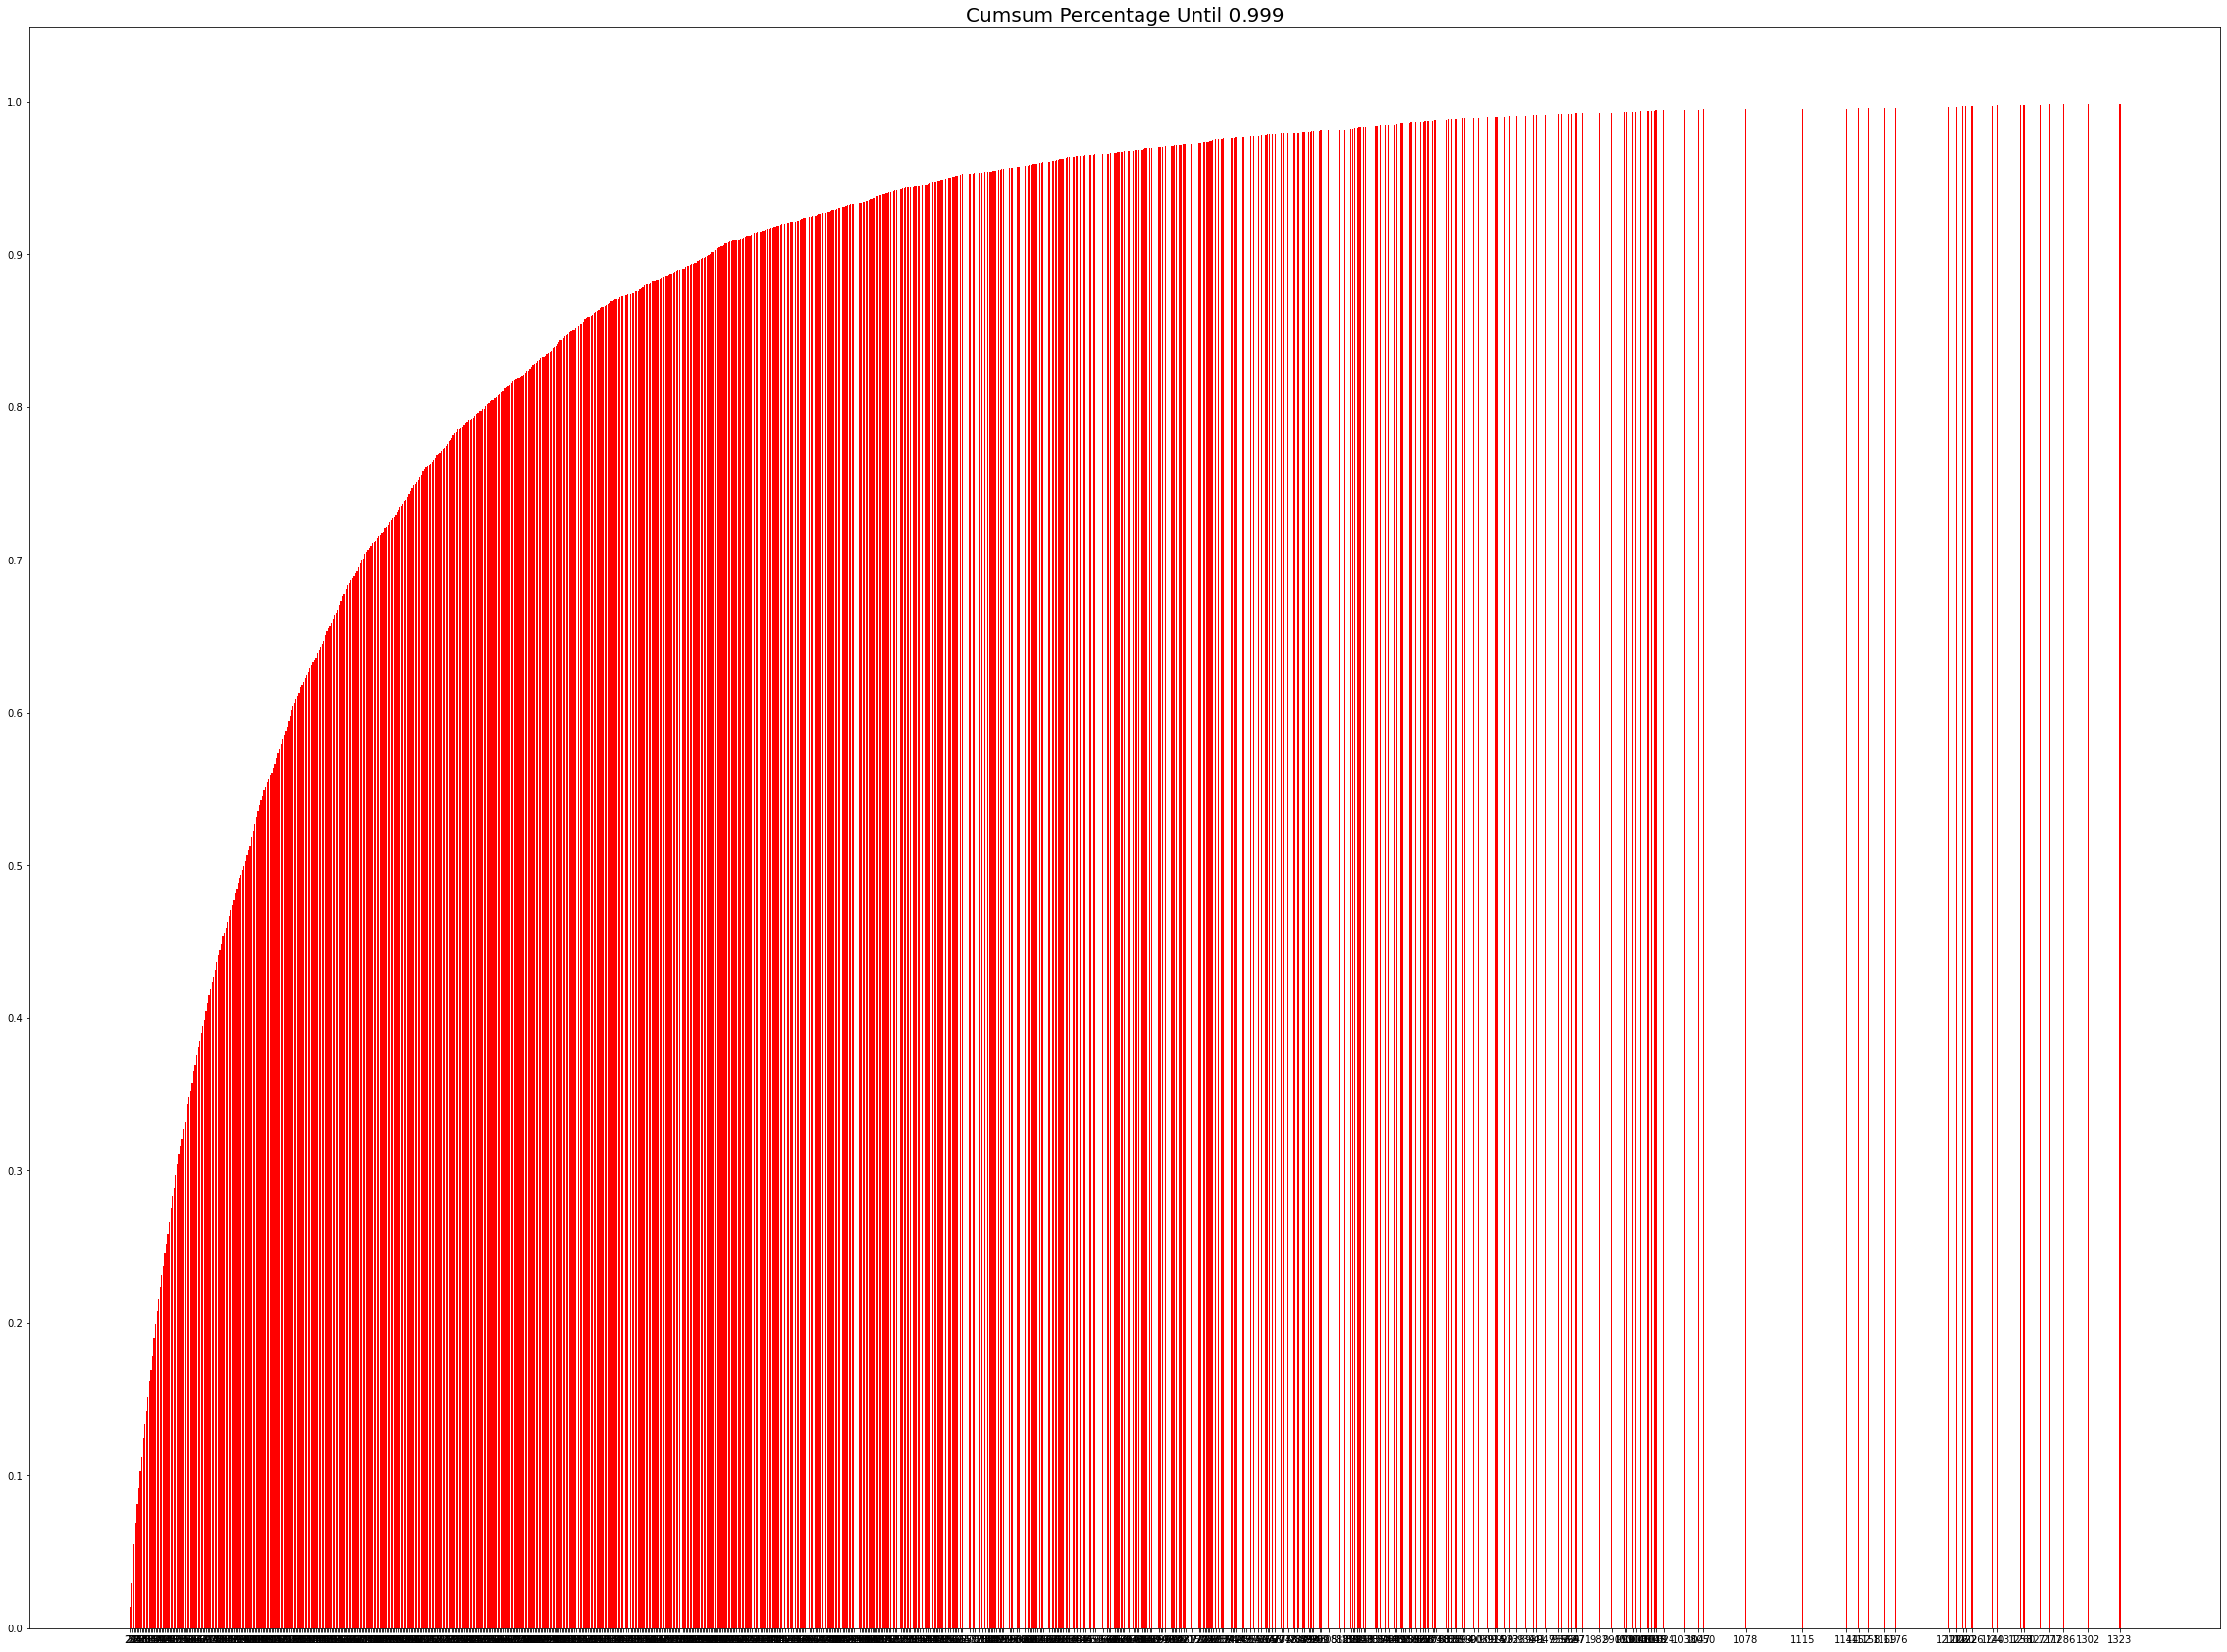

In [128]:
# 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(40, 30))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.1))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

### Session Time

---

데이터가 발생한 시간, 데이터의 시간 정보에 대해 알아보자.

In [150]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)

956703932
1046454590


In [151]:
# latest 데이터 타입
type(latest)

numpy.int64

### 데이터를 timestamp로부터 UTC time으로 변경해주자

In [152]:
from datetime import datetime

for i, time in enumerate(data['Time']):
    data['Time'][i] = datetime.utcfromtimestamp(time)

In [174]:
data

,UserId,ItemId,Rating,Time
0,1,1193,5,2000-12-31 22:00:19
3,1,3408,4,2000-12-31 22:00:55
2,1,914,3,2000-12-31 22:00:55
1,1,661,3,2000-12-31 22:00:55
4,1,2355,5,2000-12-31 22:01:43
...,...,...,...,...
1000204,6040,1091,1,2001-08-10 14:40:29
1000206,6040,562,5,2001-08-10 14:41:04
1000205,6040,1094,5,2001-08-10 14:41:04
1000207,6040,1096,4,2001-08-10 14:41:26


In [154]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)

#데이터 타입
type(latest)

2000-04-25 23:05:32
2003-02-28 17:49:50


datetime.datetime

In [155]:
month_ago = latest - dt.timedelta(30)     # 최종 날짜로부터 30일 이전 날짜를 구한다.  
test_data = data[data['Time'] > month_ago]   # 방금 구한 날짜 이후의 데이터만 모은다. 
test_data

,UserId,ItemId,Rating,Time
28546,195,1243,4,2003-02-11 18:38:15
28548,195,1172,5,2003-02-11 18:42:28
28553,195,1247,5,2003-02-16 01:27:14
28539,195,565,5,2003-02-11 17:42:36
28550,195,2985,5,2003-02-16 01:27:14
...,...,...,...,...
984895,5950,1077,3,2003-02-27 17:58:54
984904,5950,555,3,2003-02-27 18:12:49
984907,5950,1094,3,2003-02-27 18:15:10
984881,5950,507,3,2003-02-27 17:50:41


In [175]:
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
0,1,1193,5,2000-12-31 22:00:19
3,1,3408,4,2000-12-31 22:00:55
2,1,914,3,2000-12-31 22:00:55
1,1,661,3,2000-12-31 22:00:55
4,1,2355,5,2000-12-31 22:01:43
...,...,...,...,...
1000204,6040,1091,1,2001-08-10 14:40:29
1000206,6040,562,5,2001-08-10 14:41:04
1000205,6040,1094,5,2001-08-10 14:41:04
1000207,6040,1096,4,2001-08-10 14:41:26


### Data Cleansing

길이가 적은 세션 제거, 너무 적게 클릭된 아이템 제거

--> 데이터가 너무 적은 관계로, cleansing을 하지 않았다

In [136]:
# short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있습니다.
# 이를 위해 반복문을 통해 지속적으로 제거 합니다.
def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('UserId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['UserId'].isin(session_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('UserId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['UserId'].isin(item_use)]
    return data

In [176]:
data.head()

,UserId,ItemId,Rating,Time
0,1,1193,5,2000-12-31 22:00:19
3,1,3408,4,2000-12-31 22:00:55
2,1,914,3,2000-12-31 22:00:55
1,1,661,3,2000-12-31 22:00:55
4,1,2355,5,2000-12-31 22:01:43


In [182]:
data = cleanse_recursive(data, shortest=2, least_click=5)
data

,UserId,ItemId,Rating,Time
0,1,1193,5,2000-12-31 22:00:19
3,1,3408,4,2000-12-31 22:00:55
2,1,914,3,2000-12-31 22:00:55
1,1,661,3,2000-12-31 22:00:55
4,1,2355,5,2000-12-31 22:01:43
...,...,...,...,...
1000204,6040,1091,1,2001-08-10 14:40:29
1000206,6040,562,5,2001-08-10 14:41:04
1000205,6040,1094,5,2001-08-10 14:41:04
1000207,6040,1096,4,2001-08-10 14:41:26


In [185]:
data.tail(30)

,UserId,ItemId,Rating,Time
1000179,6040,2762,4,2000-07-28 23:58:26
1000181,6040,508,4,2000-07-28 23:58:54
1000180,6040,1036,3,2000-07-28 23:58:54
1000182,6040,1041,4,2000-07-28 23:59:42
1000183,6040,3735,4,2000-07-28 23:59:42
1000184,6040,2791,4,2000-07-28 23:59:59
1000185,6040,2794,1,2000-07-29 00:01:40
1000186,6040,527,5,2001-03-10 03:41:22
1000187,6040,2003,1,2001-08-10 14:29:22
1000189,6040,2010,5,2001-08-10 14:29:56


### Train, valid, test dataset split

데이터의 양이 적은 관계로, 이전과 달리 data를 30일만 남기고 자르지 않고 사용했다.

In [186]:
data.sort_values(['Time', 'UserId'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
999868,6040,573,4,2000-04-25 23:05:32
999869,6040,589,4,2000-04-25 23:05:54
999870,6040,1,3,2000-04-25 23:05:54
999872,6040,592,2,2000-04-25 23:06:17
999871,6040,2068,4,2000-04-25 23:06:17
...,...,...,...,...
825876,4958,565,2,2003-02-28 17:45:38
825877,4958,2043,1,2003-02-28 17:47:23
825878,4958,2046,5,2003-02-28 17:49:08
825879,4958,3786,4,2003-02-28 17:49:08


In [187]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('UserId')['Time'].max()
    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['UserId'].isin(session_in_train)]
    after_date = data[data['UserId'].isin(session_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

In [196]:
day_ago = latest - dt.timedelta(2)     
train_data = data[data['Time'] < day_ago]   # 방금 구한 날짜 이후의 데이터만 모은다. 
train_data

,UserId,ItemId,Rating,Time
999868,6040,573,4,2000-04-25 23:05:32
999869,6040,589,4,2000-04-25 23:05:54
999870,6040,1,3,2000-04-25 23:05:54
999872,6040,592,2,2000-04-25 23:06:17
999871,6040,2068,4,2000-04-25 23:06:17
...,...,...,...,...
261308,1597,1093,2,2003-02-26 16:13:30
261309,1597,1097,4,2003-02-26 16:15:09
261310,1597,1240,4,2003-02-26 16:17:19
261311,1597,3928,4,2003-02-26 16:17:34


In [173]:
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
0,1,1193,5,2000-12-31 22:00:19
3,1,3408,4,2000-12-31 22:00:55
2,1,914,3,2000-12-31 22:00:55
1,1,661,3,2000-12-31 22:00:55
4,1,2355,5,2000-12-31 22:01:43
...,...,...,...,...
1000204,6040,1091,1,2001-08-10 14:40:29
1000206,6040,562,5,2001-08-10 14:41:04
1000205,6040,1094,5,2001-08-10 14:41:04
1000207,6040,1096,4,2001-08-10 14:41:26


In [188]:
#tr, test = split_by_date(data, n_days=1)
#tr, val = split_by_date(tr, n_days=1)

In [191]:
day_ago = latest - dt.timedelta(2)     
split_data = data[data['Time'] > day_ago]   # 방금 구한 날짜 이후의 데이터만 모은다. 
split_data

,UserId,ItemId,Rating,Time
879536,5312,569,3,2003-02-27 04:30:55
879537,5312,2040,4,2003-02-27 04:40:36
273419,1647,2986,4,2003-02-27 05:15:05
34042,229,3786,5,2003-02-27 06:02:19
34043,229,1246,5,2003-02-27 06:04:15
...,...,...,...,...
825876,4958,565,2,2003-02-28 17:45:38
825877,4958,2043,1,2003-02-28 17:47:23
825878,4958,2046,5,2003-02-28 17:49:08
825879,4958,3786,4,2003-02-28 17:49:08


In [192]:
day_ago = latest - dt.timedelta(1)     
val_data = split_data[split_data['Time'] < day_ago]   # 방금 구한 날짜 이후의 데이터만 모은다. 
val_data

,UserId,ItemId,Rating,Time
879536,5312,569,3,2003-02-27 04:30:55
879537,5312,2040,4,2003-02-27 04:40:36
273419,1647,2986,4,2003-02-27 05:15:05
34042,229,3786,5,2003-02-27 06:02:19
34043,229,1246,5,2003-02-27 06:04:15
63597,424,2986,3,2003-02-27 12:31:39
562872,3462,1246,5,2003-02-27 13:14:14
562873,3462,1247,4,2003-02-27 13:14:38
773061,4607,1095,5,2003-02-27 14:03:45
773062,4607,562,4,2003-02-27 14:10:10


In [193]:
day_ago = latest - dt.timedelta(1)     
test_data = split_data[split_data['Time'] > day_ago]   # 방금 구한 날짜 이후의 데이터만 모은다. 
test_data

,UserId,ItemId,Rating,Time
984881,5950,507,3,2003-02-27 17:50:41
984882,5950,508,5,2003-02-27 17:51:03
984883,5950,2791,3,2003-02-27 17:51:30
984884,5950,2794,3,2003-02-27 17:51:30
984886,5950,2000,2,2003-02-27 17:53:18
984885,5950,2797,2,2003-02-27 17:53:18
984887,5950,2001,2,2003-02-27 17:53:37
984888,5950,2003,2,2003-02-27 17:53:49
984889,5950,1061,4,2003-02-27 17:54:22
984890,5950,532,4,2003-02-27 17:54:22


In [194]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [197]:
stats_info(train_data, 'train')
stats_info(val_data, 'valid')
stats_info(test_data, 'test')

* train Set Stats Info
	 Events: 1000148
	 Sessions: 6040
	 Items: 3706
	 First Time : 2000-04-25 23:05:32
	 Last Time : 2003-02-26 16:18:03

* valid Set Stats Info
	 Events: 18
	 Sessions: 7
	 Items: 16
	 First Time : 2003-02-27 04:30:55
	 Last Time : 2003-02-27 17:45:48

* test Set Stats Info
	 Events: 43
	 Sessions: 7
	 Items: 40
	 First Time : 2003-02-27 17:50:41
	 Last Time : 2003-02-28 17:49:50



In [198]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(train_data['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

train_data = indexing(train_data, id2idx)
val_data = indexing(val_data, id2idx)
test_data = indexing(test_data, id2idx)

In [180]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

train_data.to_pickle(save_path / 'train.pkl')
val_data.to_pickle(save_path / 'valid.pkl')
test_data.to_pickle(save_path / 'test.pkl')

## Step 2. 미니 배치의 구성
---
실습 코드 내역을 참고하여 데이터셋과 미니 배치를 구성해 봅시다. Session-Parallel Mini-Batch의 개념에 따라, 학습 속도의 저하가 최소화될 수 있도록 구성합니다.
단, 위 Step 1에서 Session 단위를 어떻게 정의했느냐에 따라서 Session-Parallel Mini-Batch이 굳이 필요하지 않을 수도 있습니다.

### Session Dataset

세션을 정의하는 클래스를 만들자.

In [181]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

train data로 SessionDataset 객체를 만들고 인스턴스 변수를 살펴보자.

session_idx 변수는 각 세션을 인덱싱한 np.array이다.

In [224]:
train_dataset = SessionDataset(train_data)
train_dataset.df.head(10)

,UserId,ItemId,Rating,Time,item_idx
999868,6040,573,4,2000-04-25 23:05:32,0
999869,6040,589,4,2000-04-25 23:05:54,1
999870,6040,1,3,2000-04-25 23:05:54,2
999872,6040,592,2,2000-04-25 23:06:17,3
999871,6040,2068,4,2000-04-25 23:06:17,4
999873,6040,593,5,2000-04-25 23:07:36,5
999877,6040,1419,3,2000-04-25 23:07:36,6
999876,6040,2070,4,2000-04-25 23:07:36,7
999874,6040,3016,2,2000-04-25 23:07:36,8
999875,6040,3017,1,2000-04-25 23:07:36,9


In [225]:
train_dataset.click_offsets

array([      0,      53,     182, ...,  999684,  999807, 1000148],
      dtype=int32)

In [226]:
train_dataset.session_idx

array([   0,    1,    2, ..., 6037, 6038, 6039])

### SessionDataLoader

Session Dataset 객체를 받아서 Session-Parallel mini-batch를 만드는 클래스를 만들자.

`__iter__`는 모델 인풋, 라벨, 세션이 끝나는 위치를 yield한다.

`Mask`는 후에 `RNN Cell State`를 초기화할때 사용한다.

In [202]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]  # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [203]:
train_data_loader = SessionDataLoader(train_dataset, batch_size=4)
train_dataset.df.head(15)

,UserId,ItemId,Rating,Time,item_idx
999868,6040,573,4,2000-04-25 23:05:32,0
999869,6040,589,4,2000-04-25 23:05:54,1
999870,6040,1,3,2000-04-25 23:05:54,2
999872,6040,592,2,2000-04-25 23:06:17,3
999871,6040,2068,4,2000-04-25 23:06:17,4
999873,6040,593,5,2000-04-25 23:07:36,5
999877,6040,1419,3,2000-04-25 23:07:36,6
999876,6040,2070,4,2000-04-25 23:07:36,7
999874,6040,3016,2,2000-04-25 23:07:36,8
999875,6040,3017,1,2000-04-25 23:07:36,9


In [204]:
iter_ex = iter(train_data_loader)

In [205]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [ 0 53 22 42]
Label Item Idx are :       [ 1 54  6 41]
Previous Masked Input Idx are []


In [209]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [  2  55  95 193]
Label Item Idx are :       [ 3 56 56 43]
Previous Masked Input Idx are []


In [210]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [ 3 56 56 43]
Label Item Idx are :       [  4  57 105 194]
Previous Masked Input Idx are []


## Step 3. 모델 구성
---

이 부분도 실습 코드 내역을 참고하여 다양하게 모델 구조를 시도해 볼 수 있습니다.

### Evaluation Matric

recall@k, Mean Average Precision@k 를 사용하자.

In [211]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

### Model Architecture
모델 구조를 구현한다.

In [212]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [213]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [252]:
# 모델에 사용할 hyper-parameter를 class 형식으로 관리한다.

class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(train_data, val_data, test_data, batch_size=2, hsz=50, drop_rate=0.1, lr=0.001, epochs=1, k=20)

In [253]:
model = create_model(args)

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(2, 1, 3706)]            0         
_________________________________________________________________
GRU (GRU)                    [(2, 50), (2, 50)]        563700    
_________________________________________________________________
dropout_7 (Dropout)          (2, 50)                   0         
_________________________________________________________________
dense_7 (Dense)              (2, 3706)                 189006    
Total params: 752,706
Trainable params: 752,706
Non-trainable params: 0
_________________________________________________________________


### Model Training

모델 학습

In [254]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [255]:
# 학습 시간이 다소 오래 소요됩니다. 아래 주석을 풀지 마세요.
train_model(model, args)
##자꾸 오류가 나서, 추척을 하다가 get_matric 부분에서 타고 타고, args에있는 k값 파라미터를 20에서 2로 바꿨음
## 똑같이 args에서 batch size도 2048에서 36->2으로 내렸는데, 안됨! 원상복구할것

# 학습된 모델을 불러옵니다.
#model = tf.keras.models.load_model(data_path / 'trained_model')

Evaluation:  80%|████████  | 4/5 [00:00<00:00, 11.50it/s]

	 - Recall@20 epoch 1: 0.625000
	 - MRR@20    epoch 1: 0.239583



### Inference

모델의 성능을 validate

In [261]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test_data)

Evaluation:  39%|███▉      | 7/18 [00:00<00:00, 26.58it/s]

	 - Recall@20: 0.785714
	 - MRR@20: 0.306494



# 회고

1. 어려웠던 점, 해결 방안

- 기존 방식과 다르게, timestamp를 이해하고, 이를 UTC time으로 변경해주어야 했다.   
- 처음에 learning을 돌리니, index 에러와 batch_size가 잘못된건지 에러가 났다. k값을 바꾸고, batch_size를 36으로 하니 동일하게 에러가 났다. 사이즈를 2로 줄이니 해결되었다. 원인을 분석하자면, val data의 크기보다 batch_size가 커서 오류가 나지 않았나 싶다.   
- 여러 하이퍼 파라미터들을 바꿔가면서 학습을 하는 데 시간이 오래 걸렸다.   
